# Chapter 3 Part 1: the random sample
author: <span style="color:magenta">Poppy Riddle</span><br>
date: Mar 31, 2025

## Data collection
This notebook collects a random sample from Crossref. Inclusion criteria include:
- date range: 2020-2025
- doc_type:journal-article, proceedings-article, book-chapter
- filter: has-abstract=1
- sample: sample size is limited to 100 per call. Multiple calls will be used. 

Total records needed:
- journal articles = 9550 (95.5%),
- proceedings-article=150 (1.5%), 
- and book-chapter=290 (2.9%


<span style="color:magenta">## to do</span><br>
Pulling data from the XML API is a pain and is inconsistent particularly for abstract and license. 
- [x] Pull all data from REST API with full metadata (otherwise language is not part of select option)**COMPLETE**
    - [X] see crossref_api.py for REST api module
IF NO DATA EXISTS FOR LANGUAGE:
- [ ] language attributes from XML API using DOIs from above

This makes getting the data for proceedings-article and book-chapter much easier and consistent. Otherwise, coding all the locations to get from the XML is too 
likely to have errors or false negatives. 


# Random selection

In [109]:
import pandas as pd
import os
import requests
import pickle
import json
from colorama import Fore,Back,Style
import time
import csv
from tqdm import tqdm

# set display options
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None) # show all columns
pd.set_option('display.max_colwidth', None)  # Show full content of each column


In [3]:
# this cell gets the random DOIs for each doc_type

# doc_type is a dictionary that includes the type (key) to be inserted into the API_URL and the quantity (value) of times the API_URL needs to be called.
doc_type = {"journal-article":100, "proceedings-article":1, "book-chapter":1}

#API_URL = f"https://api.crossref.org/works?mailto=pnriddle@dal.ca&filter=from-pub-date:2020-01-01,has-abstract:1,type:{doc_type}&select=DOI&sample=10"

# URL and params - the requests library concats with &
# moved params to within the for loop
API_URL = "https://api.crossref.org/works?"

# dictionary of dataframes to store the results for each document type
dfs = {}

start = time.time()
# Send API calls for each document type and collect the results
for doc_type, num_samples in doc_type.items():
    params = {
    "mailto": "pnriddle@dal.ca",
    "filter": "from-pub-date:2020-01-01,has-abstract:1",
    "select": "DOI",
    "sample": 10}
    params["filter"] += f",type:{doc_type}"
    results = []
    for i in tqdm(range(num_samples),colour='cyan'):
        response = requests.get(API_URL, params=params)
        # Print the URL and parameters for the API call to check
        #print(f"API call {i+1}: {response.url}") 
        data = response.json()
        #print(data)
        for item in data['message']['items']:
            results.append({'DOI': item['DOI']})
        # for rate limiting
        time.sleep(0.2)
    dfs[doc_type] = pd.DataFrame(results)
time_stop = time.time()-start
print(Fore.CYAN + f" time to complete: {time_stop:.2f}")
# Collate the results into a single dataframe
df_collated = pd.concat(dfs.values(), keys=dfs.keys())
print(Fore.MAGENTA + "Done")
df_collated



  8%|▊         | 8/100 [00:21<04:02,  2.64s/it]


KeyboardInterrupt: 

In [72]:
# Save the data as a pickle for future use
with open('Part_1_random_sample_DOI_data.pkl', 'wb') as f:
    pickle.dump(df_collated, f)

# Save the data as a CSV file
df_collated.to_csv('Part_1_random_sample_DOI_data.csv', sep='\t')

# XML API call
- 😭 Have abandoned this for the time being as its too complicated
- 💪🏻 change to a module for later

In [6]:
"""
sends an API call to the Crossref XML API
returns document type, citedby_count, title, abstract, url, and license
"""

def get_xml_data(doi):
    XML_API = f"https://doi.crossref.org/search/doi?pid=pnriddle@dal.ca&format=unixsd&doi={doi}"
    #make API call 
    response = requests.get(XML_API)
    xml_data = response.content
    output = xmltodict.parse(xml_data)
    print(output)

    doi_type = output['crossref_result']['query_result']['body']['query']['doi']['@type']
    print(Fore.MAGENTA + f"doi_type: {doi_type}")

    doi_xml = output['crossref_result']['query_result']['body']['query']['doi']['#text']
    print(Fore.CYAN + f"doi_xml: {doi_xml}")

    citedby_count = output['crossref_result']['query_result']['body']['query']['crm-item'][9]['#text']
    print(Fore.YELLOW + f"citedby_count: {citedby_count}")

    # journal_article title
    try:
        title = output['crossref_result']['query_result']['body']['query']['doi_record']['crossref']['journal']['journal_article']['titles']['title']
        if not title:
            # can stack other locations for other doc_types
            title = " no title"
    except (KeyError,TypeError) as e:
        print(f"ah nuts, an error: {e}")
        title = "no title"
    print(Fore.MAGENTA + f"title: {title}")
    # look into .flatten() to flatten the lists if they exist
    
    #this is just for journal_article lists
    try:
        abstract_element = output['crossref_result']['query_result']['body']['query']['doi_record']['crossref']['journal']['journal_article']['jats:abstract']
        if isinstance(abstract_element, list):
            abstract = []
            for elem in abstract_element:
                language = elem.get('@xml:lang')
                text = elem.get('jats:sep')
                abstract.append({'language':language,'text':text})
        else:
            language = abstract_element.get('@xml:lang')
            text = abstract_element.get('jats:p')
            abstract = {'language':language,'text':text}
    except:
        abstract = None
    print(Fore.CYAN + f"abstract: {abstract}")

    # URL retrieval
    try:
        doi_url = output['crossref_result']['query_result']['body']['query']['doi_record']['crossref']['journal']['journal_article']['doi_data']['resource'].format('#text')
        if not doi_url:
            doi_url = output['crossref_result']['query_result']['body']['query']['doi_record']['crossref']['journal']['journal_article']['doi_data']['resource']
            if not doi_url:
                print(Fore.YELLOW + f" das ist nicht so gut")
                doi_url = "no resolution url"
    except Exception as e:
        print(Fore.YELLOW + f" ah boo: {e}")
        doi_url = "no resolution url"            
    print(Fore.YELLOW + f"doi_url: {doi_url}")

    #license
    """
    this part is very complex as there are multiple locations where license can be supplied. May want to pull this field from the REST API
    just to keep it simple. See locations here: https://data.crossref.org/reports/help/schema_doc/5.3.1/index.html

    tried - license is too messy - get license from REST API call

    or resolve this in the Crossref_XML_API module
    """



    data = {'doi':doi,
            'doi_type':doi_type,
            'title':title,
            'abstract':abstract,
            'citedby_count':citedby_count,
            'doi_url':doi_url,
            }

    # time delay for rate limiting
    time.sleep(1)

    return data



In [7]:
get_xml_data("10.1088/1755-1315/899/1/012022")

{'crossref_result': {'@xmlns': 'http://www.crossref.org/qrschema/3.0', '@version': '3.0', '@xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance', '@xsi:schemaLocation': 'http://www.crossref.org/qrschema/3.0 http://www.crossref.org/schemas/crossref_query_output3.0.xsd', 'query_result': {'head': {'doi_batch_id': 'none'}, 'body': {'query': {'@status': 'resolved', 'doi': {'@type': 'journal_article', '#text': '10.1088/1755-1315/899/1/012022'}, 'crm-item': [{'@name': 'publisher-name', '@type': 'string', '#text': 'IOP Publishing'}, {'@name': 'prefix-name', '@type': 'string', '#text': 'IOP Publishing'}, {'@name': 'member-id', '@type': 'number', '#text': '266'}, {'@name': 'citation-id', '@type': 'number', '#text': '132521094'}, {'@name': 'journal-id', '@type': 'number', '#text': '75384'}, {'@name': 'deposit-timestamp', '@type': 'number', '#text': '2022030117155000'}, {'@name': 'owner-prefix', '@type': 'string', '#text': '10.1088'}, {'@name': 'last-update', '@type': 'date', '#text': '2022-03-

{'doi': '10.1088/1755-1315/899/1/012022',
 'doi_type': 'journal_article',
 'title': 'The gap of cultural heritage protection with climate change adaptation in the context of spatial planning. The case of Greece',
 'abstract': {'language': None,
  'text': 'The case of cultural resources, and in particular of archaeological sites, is one of the key elements of the anthropogenic environment that is affected by climate change and needs protection. At the same time, it is a field of analysis allowing the understanding of the interactions and interconnections of natural and socio-economic systems in time and in different spatial scales, thus providing useful information on the phenomenon of climate change and on how to respond and adapt to it [1]. However, the related scientific research, policies and actions are still limited, as only in the last decade [2] there has been an (albeit ever-increasing) interest in this field. The main objective of this paper is to codify protection policies an

In [8]:
# apply function to df_collated['DOI']
#df_collated['XML_data'] = df_collated['DOI'].apply(get_xml_data)

#df_collated(

xml_data = df_collated['DOI'].apply(get_xml_data)

df_collated2 = pd.DataFrame(xml_data.to_list())

df_collated2

{'crossref_result': {'@xmlns': 'http://www.crossref.org/qrschema/3.0', '@version': '3.0', '@xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance', '@xsi:schemaLocation': 'http://www.crossref.org/qrschema/3.0 http://www.crossref.org/schemas/crossref_query_output3.0.xsd', 'query_result': {'head': {'doi_batch_id': 'none'}, 'body': {'query': {'@status': 'resolved', 'doi': {'@type': 'journal_article', '#text': '10.1093/ofid/ofae631.2509'}, 'crm-item': [{'@name': 'publisher-name', '@type': 'string', '#text': 'Oxford University Press (OUP)'}, {'@name': 'prefix-name', '@type': 'string', '#text': 'Oxford University Press'}, {'@name': 'member-id', '@type': 'number', '#text': '286'}, {'@name': 'citation-id', '@type': 'number', '#text': '171088840'}, {'@name': 'journal-id', '@type': 'number', '#text': '238193'}, {'@name': 'deposit-timestamp', '@type': 'number', '#text': '2025012919011032600'}, {'@name': 'owner-prefix', '@type': 'string', '#text': '10.1093'}, {'@name': 'last-update', '@type': 'da

,doi,doi_type,title,abstract,citedby_count,doi_url
0,10.1093/ofid/ofae631.2509,journal_article,"P-2358. Viral etiologies of bronchiolitis, pne...","{'language': None, 'text': None}",0,https://academic.oup.com/ofid/article/doi/10.1...
1,10.31000/jiki.v4i2.3101,journal_article,Cupping Therapy Improves Quality of Life in Ph...,"{'language': None, 'text': 'Hypertension is th...",0,https://jurnal.umt.ac.id/index.php/jik/article...
2,10.1055/a-1890-5878,journal_article,Whipple’s Disease – delay of diagnosis by immu...,"{'language': 'en', 'text': ['Background Risk f...",1,http://www.thieme-connect.de/DOI/DOI?10.1055/a...
3,10.55367/ivhy6689,journal_article,Administration of Justice in Medical Disputes ...,"{'language': 'ka', 'text': 'სამედიცინო მომსახუ...",0,https://journal.ciu.edu.ge/article/31
4,10.51298/vmj.v530i1b.6680,journal_article,KẾT QUẢ SỬ DỤNG SURFACTANT LIỀU CAO TRONG ĐIỀU...,"{'language': None, 'text': 'Đánh giá kết quả s...",0,https://tapchiyhocvietnam.vn/index.php/vmj/art...
5,10.54033/cadpedv21n5-110,journal_article,Tecnologias digitais e metodologias ativas na ...,"{'language': None, 'text': 'Este trabalho abor...",0,https://ojs.studiespublicacoes.com.br/ojs/inde...
6,10.15407/microbiolj84.01.057,journal_article,The Role of Intestinal Microbiota and Its Reco...,"{'language': 'en', 'text': 'Today, during the ...",1,http://microbiolj.org.ua/en/archiv/2022-tom-84...
7,10.37614/2307-5252.2021.2.5.045,journal_article,Structure and mechanical properties of rapidly...,"{'language': 'en', 'text': 'The results of the...",1,https://rio.ksc.ru/data/documents/trudy-2-2021...
8,10.37934/araset.29.3.251259,journal_article,Augmented Reality (AR) as A Promotion Tool in ...,"{'language': 'en', 'text': 'Contemporary rapid...",3,https://semarakilmu.com.my/journals/index.php/...
9,10.54065/dieksis.1.1.2021.47,journal_article,Hubungan Kebiasaan Membaca Terhadap Kemampuan ...,"{'language': None, 'text': 'Penelitian ini ber...",1,https://pusdig.my.id/dieksis/article/view/47


In [9]:
# get some more info on the 'abstract' column
df_collated2['abstract_keys_count'] = df_collated2['abstract'].apply(lambda x: len(x) if isinstance(x,dict) else 0)

# or see if its a list
df_collated2['abstract_type'] = df_collated2['abstract'].apply(lambda x:'list' if isinstance(x, list) else 'dict')


In [10]:
## GET LICENSE DATA FROM REST API
def get_rest_license(doi):
    URL = f"https://api.crossref.org/works/{doi}"
    result = requests.get(URL)
    # return JSON result
    if result.status_code == 200:
        data = result.json()
        # retrieve the license if the content-version = "vor", return the URL value
        if 'message' in data and 'license' in data['message']:
            licenses = data['message']['license']
            for license in licenses:
                if 'content-version' in license and license['content-version'] == 'vor':
                    print(Fore.MAGENTA + f"license: {license['URL']}")
                    return {'license': license['URL']}
    return {'license': 'no license'}
    time.sleep(1)
    print(Style.RESET)



In [11]:
license_data = df_collated['DOI'].apply(get_rest_license)

df_license = pd.DataFrame(license_data.to_list())

df_collated2 = df_collated2.reset_index().merge(df_license.reset_index(), on='index')


license: https://creativecommons.org/licenses/by/4.0/


In [12]:
# save out the goods
folder_to_be_saved = 'data'
if not os.path.exists(folder_to_be_saved):
    os.makedirs(folder_to_be_saved)
#export as .csv but tab separated
file_to_be_saved = os.path.join(folder_to_be_saved, "part_1_sample.csv")

df_collated2.to_csv(file_to_be_saved, sep='\t', encoding='utf-8',na_rep='NA')

# also save out as pickle to preserve data types
pkl_to_be_saved = os.path.join(folder_to_be_saved, "part_1_sample.pkl")
df_collated2.to_pickle(pkl_to_be_saved)



# Crossref_REST_API module
see the crossref_api.py module. 
You can call help(crossref_api) for documentation


In [67]:
help(Crossref_REST_API)

In [8]:
# move this file to a more central and reusable location once working properly 
# and update the path
import sys
sys.path.append("/Users/poppyriddle/Documents/Github/Research_proposal")
from crossref_api import Crossref_REST_API

In [73]:
# apply function to df_collated['DOI']
from tqdm import tqdm
tqdm.pandas(desc="progress",colour='magenta')
 #create a series from the main df
rest_data = df_collated['DOI']
# convert to a dataframe
rest_data = pd.DataFrame(rest_data)
#apply the Crossref_REST_API function
def sleep_and_call_api(doi):
    time.sleep(0.2)
    return Crossref_REST_API(doi)

#NOTE: this has a tqdm progress bar, so use progress_apply() instead of apply()
#source:https://github.com/tqdm/tqdm#pandas-integration
rest_data['object'] = rest_data['DOI'].progress_apply(sleep_and_call_api)

# apply the methods to extract the data for each
rest_data['type'] = rest_data['object'].apply(lambda x: x.get_type())
rest_data['title'] = rest_data['object'].apply(lambda x: x.get_title())
rest_data['abstract'] = rest_data['object'].apply(lambda x: x.get_abstract())
rest_data['language'] = rest_data['object'].apply(lambda x: x.get_language())
rest_data['license'] = rest_data['object'].apply(lambda x: x.get_license())
rest_data['cited_by'] = rest_data['object'].apply(lambda x: x.get_cited_by())
rest_data['url'] = rest_data['object'].apply(lambda x: x.get_url())

print(Fore.MAGENTA + "all done")



progress: 100%|██████████| 30/30 [00:06<00:00,  4.91it/s]


all done


In [74]:
# save out the goods
folder_to_be_saved = 'data'
if not os.path.exists(folder_to_be_saved):
    os.makedirs(folder_to_be_saved)
#export as .csv but tab separated
file_to_be_saved = os.path.join(folder_to_be_saved, "part_1_sample_collected.csv")

rest_data.to_csv(file_to_be_saved, sep='\t', encoding='utf-8',na_rep='NA')

# also save out as pickle to preserve data types
pkl_to_be_saved = os.path.join(folder_to_be_saved, "part_1_sample_collected.pkl")
rest_data.to_pickle(pkl_to_be_saved)

# Analysis
Schema 5.4.0:https://gitlab.com/crossref/schema/-/blob/master/schemas/common5.4.0.xsd?ref_type=heads

and Schema definitions: https://data.crossref.org/reports/help/schema_doc/5.3.1/index.html 

info on abstracts: https://www.crossref.org/documentation/schema-library/markup-guide-metadata-segments/abstracts/

## Outcomes of the analysis
### Quantitative analysis:
- [ ] boolean values for presence of each metadata element by document type
    - publication type
    - title
    - abstract
    - citedby
    - resolution URL
    - license version
    - license URL
    - language
- [ ] DOI:
    - http or https count
    - https status code
    - working or not (boolean value)
- [ ] publication type and subtype:
    - count and % of each type (this may not be necessary becaue I controlled this in the sampling)
- [ ] title:
    - count of tokens, stop words, punctuation, special char, formatting char, numerals, non-text elements
    - descriptive analysis
- [ ] abstract:
    - count of tokens, stop words, punctuation, special char, formatting char, numerals, non-text elements
    - descriptive analysis
- [ ] citedby_count
    - line chart or histogram
- [ ] license
    - type ,count, %, common or proprietary - may need much cleaning to get this info and may have to do after the qual evaluation
- [ ] language
    - type, count of each type, % in abstract, % in journal level attribution


- [ ] License - identification of locations, difference between REST and XML API
    - types:
        - [ ] errors in consistency, conventions such as with CC-BY, etc. 
        - [ ] coded for incorrect values, missing info, and inconsistent value rep
        - [ ] sample of types that are non-CC
- [ ] Title and abstract
    - subset used for screening error types:
        - contains both languages  
        - language not consistent with language attribute 
        - duplicate characters  
        - NA for title  
        - all caps  
        - includes web address  
        - includes conference location name, date  
        - inclusion of HTML text formatting codes/face markup  
        - inclusion of numbers or characters not in title  
        - includes full citation  
        - includes isbn  
        - nonsense title/placeholder  
        - includes author 
    - applied to rest of sample for counts
    - coded for inconsistent value rep    



In [4]:
import numpy as np

In [5]:
# load pickled data 

with open('data/part_1_sample_collected.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not have to specify it.
    data = pickle.load(f)

# create dataframe
df_data = pd.DataFrame(data)

# unpack 'license' into 'license_version' and 'license_type'
df_data[['license_version', 'license_type']] = df_data['license'].apply(lambda x:pd.Series(x))
# handle empty values

# remove 'object' and 'license'
df_data.drop(columns=['object','license'], inplace=True)

# handle missing values
df_data.isnull().sum()
df_data.dtypes
df_data.replace({None:np.nan,'None':np.nan}, inplace=True)
df_data.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30 entries, ('journal-article', 0) to ('book-chapter', 9)
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DOI              30 non-null     object
 1   type             30 non-null     object
 2   title            30 non-null     object
 3   abstract         30 non-null     object
 4   language         11 non-null     object
 5   cited_by         30 non-null     int64 
 6   url              30 non-null     object
 7   license_version  11 non-null     object
 8   license_type     11 non-null     object
dtypes: int64(1), object(8)
memory usage: 2.4+ KB


- [ ] boolean values for presence of each metadata element by document type
    - publication type
    - title
    - abstract
    - citedby
    - resolution URL
    - license version
    - license URL
    - language

In [6]:
# join back up with original dataframe to get the document type column to be able to groupby
df_data_count = df_data.groupby(by='type').count()

df_data_count.style.set_properties(**{'background-color': 'cyan',
                                'color': 'magenta',
                                'border-color': 'yellow'})

df_data_count




,DOI,title,abstract,language,cited_by,url,license_version,license_type
type,,,,,,,,
book-chapter:None,10,10,10,6,10,10,1,1
journal-article:None,10,10,10,5,10,10,8,8
proceedings-article:None,10,10,10,0,10,10,2,2


- [ ] DOI:
    - http or https count
    - https status code
    - working or not (boolean value)

- see documentation on status codes here:
https://developer.mozilla.org/en-US/docs/Web/HTTP/Reference/Status

In [7]:
# counts for each type
# need to make function for https code

from urllib.parse import urlparse

def check_status_code(url:str)-> str:
    """
    This function takes a URL as input and returns a string for 'Valid' or 'Invalid'. 
    It checks if both the scheme ('https', etc) and the location (www.wikipedia.com) are present

    Returns
    str
        "Invalid URL scheme or netloc" - this means the URL is missing the scheme or netlocation.
        "Invalid URL" - this means that the response code was not received and the attempt failed.
        Status code - this is a status code that must be interpreted. 

    Example:
    200 - This is a valid and functioning URL
    404 - Page not found. 
    """
    result = urlparse(url)
    if not result.scheme and result.netloc:
        return "Invalid URL scheme or netloc"
    
    try:
        response = requests.get(url, timeout=5) # timeout in 5 seconds
        # rate limiting
        time.sleep(.5)
        return str(response.status_code)
    except requests.exceptions.RequestException:
        return "Attempt failed"



In [8]:
tqdm.pandas(colour='cyan')

df_data_url = df_data[['DOI','url','type']]
df_data_url.loc[:,'status_code'] = df_data_url['url'].progress_apply(check_status_code)

100%|██████████| 30/30 [00:47<00:00,  1.57s/it]
<positron-console-cell-8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
df_data_url.loc[:,'http_scheme'] = df_data_url['url'].apply(lambda x:x.startswith('http:'))
df_data_url['http_scheme'] = df_data_url['http_scheme'].replace({True:1,False:0})

<positron-console-cell-10>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False False False False False False False False False  True False
 False  True False  True False  True False False  True False  True  True False
 False False False False]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
<positron-console-cell-10>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
<positron-console-cell-10>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [11]:
df_data_url_grouped = df_data_url.groupby(by=['type','status_code']).count()

df_data_url_grouped.style.set_properties(**{'background-color': 'cyan',
                                'color': 'magenta',
                                'border-color': 'yellow'})

df_data_url_grouped

DOI  url  http_scheme
type                     status_code                          
book-chapter:None        200               4    4            4
                         403               5    5            5
                         406               1    1            1
journal-article:None     200               5    5            5
                         403               5    5            5
proceedings-article:None 200               6    6            6
                         403               2    2            2
                         406               1    1            1
                         Attempt failed    1    1            1

In [13]:
df_data_url_http = df_data_url.groupby(by=['type','status_code','http_scheme'])['url'].count()
df_data_url_http

type                      status_code     http_scheme
book-chapter:None         200             0              1
                                          1              3
                          403             0              5
                          406             0              1
journal-article:None      200             0              5
                          403             0              5
proceedings-article:None  200             0              4
                                          1              2
                          403             0              2
                          406             1              1
                          Attempt failed  1              1
Name: url, dtype: int64

In [14]:
def working_or_not(x:str)->int:
    if x=="200":
        return 1
    else:
        return 0

df_data_url.loc[:,'working'] = df_data_url['status_code'].apply(working_or_not)

df_data_url_working = df_data_url.groupby(['type','http_scheme']).sum()
df_data_url_working.drop(['DOI','url','status_code'],axis=1, inplace=True)
df_data_url_working



<positron-console-cell-14>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


working
type                     http_scheme         
book-chapter:None        0                  1
                         1                  3
journal-article:None     0                  5
proceedings-article:None 0                  4
                         1                  2

- [ ] publication type and subtype:
    - count and % of each type (this may not be necessary becaue I controlled this in the sampling) but the subtype is a new thing

In [15]:
# type and subtype - need to unpack the tuple
df_data_type = df_data[['DOI','type']]
df_data_type.groupby('type').count()
# this sample set did not have any subtypes - maybe check this again with a larger sample set?


,DOI
type,
book-chapter:None,10
journal-article:None,10
proceedings-article:None,10


- [ ] title:
    - count of tokens, stop words, punctuation, special char, formatting char, numerals, non-text elements
    - descriptive analysis
    

In [16]:
# check on analysis from BtS - may have already done this code
df_data_title = df_data[['DOI','title','type']]
df_data_title
# count tokens

def count_tokens(x:str)->int:
    "counts the number of tokens in a title"
    token_list=(x.split(sep=" "))
    return len(token_list)

df_data_title.loc[:,'token_count'] = df_data_title['title'].apply(count_tokens)


#print(Fore.CYAN + f"Mean:\n{df_data_title.groupby('type')['token_count'].mean()}") #.mean, max, min, sum
print(Fore.GREEN + f"All three:\n{df_data_title.groupby('type')['token_count'].agg(['mean','max','min'])}")
print("---------")
pd.DataFrame(df_data_title.groupby('type')['token_count'].agg(['mean','max','min']))




All three:
                          mean  max  min
type                                    
book-chapter:None         11.9   20    2
journal-article:None      14.7   22    8
proceedings-article:None  12.8   28    8
---------


<positron-console-cell-16>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,max,min
type,,,
book-chapter:None,11.9,20,2
journal-article:None,14.7,22,8
proceedings-article:None,12.8,28,8


In [118]:
# count stop words
# ******* NOTE: NLTK only works on 3.12 or older *********
# ref: https://pythonspot.com/nltk-stop-words/
# see notes on Manual installation: https://www.nltk.org/data.html
# NLTK_DATA = "/Users/poppyriddle/nltk_data" # this is a default lookup path

import nltk
import os
from nltk.corpus import stopwords

stopWords = set(stopwords.words('english'))

def count_stopwords(x:str)->int:
    words:list = x.split(" ")
    wordsFiltered:list = [w for w in words if w not in stopWords]
    haltwords = [w for w in words if w in stopWords]
    return len(words)-len(wordsFiltered)


df_data_title['stop_word_count'] = df_data_title['title'].apply(count_stopwords)
print(Fore.LIGHTCYAN_EX+ f"mean:\n{df_data_title.groupby('type')[['token_count','stop_word_count']].mean()}")
print("---------")
print(Fore.LIGHTGREEN_EX + f"max:\n{df_data_title.groupby('type')[['token_count','stop_word_count']].max()}")
print("---------")
print(Fore.LIGHTMAGENTA_EX + f"min:\n{df_data_title.groupby('type')[['token_count','stop_word_count']].min()}")

# Count NaN values in 'title'
nan_count = df_data_title['title'].isna().sum()
print(Fore.LIGHTYELLOW_EX + f"\n------\nNumber of NaN values in 'doi' column: {nan_count}")




mean:
                          token_count  stop_word_count
type                                                  
book-chapter:None                11.9              2.0
journal-article:None             14.7              2.7
proceedings-article:None         12.8              0.9
---------
max:
                          token_count  stop_word_count
type                                                  
book-chapter:None                  20                5
journal-article:None               22                8
proceedings-article:None           28                3
---------
min:
                          token_count  stop_word_count
type                                                  
book-chapter:None                   2                0
journal-article:None                8                0
proceedings-article:None            8                0

------
Number of NaN values in 'doi' column: 0


<positron-console-cell-118>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [56]:
# numerals in titles
def check_for_numerals(x:str)->int:
    """
    count of numerals in string
    """
    numerals = 0
    for i in x:
        if i.isnumeric():
            numerals += 1
    return numerals

test = "0h my goodness, this sausage is n0 good!"
check_for_numerals(test)

#apply this to 'title'
df_data_title['numeral_count'] = df_data_title['title'].apply(check_for_numerals)
pd.DataFrame(df_data_title.groupby('type')[['numeral_count']].agg({'numeral_count':['mean','max','min','median','std']}))


<positron-console-cell-56>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


numeral_count                         
                                  mean max min median       std
type                                                           
book-chapter:None                  0.0   0   0    0.0  0.000000
journal-article:None               1.2   4   0    0.5  1.475730
proceedings-article:None           0.2   2   0    0.0  0.632456

- [ ] abstract:
    - count of tokens, stop words, punctuation, special char, formatting char, numerals, non-text elements
    - descriptive analysis

In [105]:
# abstract analysis
#create list of special formatting phrases,tokens,chars found in abstracts
# maybe use regex such as '[<*>]'? ref: https://stackoverflow.com/questions/7206499/match-letter-in-any-language

regex_pattern = "<.*?>|\\n"

#create abstract specific datarame
df_data_abstract = df_data[['type','DOI','abstract']]

matched_patterns = df_data_abstract['abstract'].str.findall(regex_pattern)
df_data_abstract['matched_patterns'] = matched_patterns

def count_patterns_matched(x:list)->int:
    return len(x)

df_data_abstract['num_pattern_matched'] = df_data_abstract['matched_patterns'].apply(count_patterns_matched)


#count tokens in abstract prior to identifying pattern
def count_tokens(x:str)->int:
    "counts the number of tokens in a title or abstract"
    token_list=(x.split(sep=" "))
    return len(token_list)

df_data_abstract.loc[:,'token_count'] = df_data_abstract['abstract'].apply(count_tokens)
    
#check for numerals
df_data_abstract.loc[:,'numeral_count'] = df_data_abstract['abstract'].apply(check_for_numerals)

# count stopwords
#count_stopwords()
df_data_abstract.loc[:,'stopword_count'] = df_data_abstract['abstract'].apply(count_stopwords)

#punctuation count
punct_pattern = "[!@#$%&*()?;:'\"]"
punct_patterns = df_data_abstract['abstract'].str.findall(punct_pattern)
df_data_abstract['punctuation_patterns'] = punct_patterns
df_data_abstract.loc[:,'punctuation_count'] = df_data_abstract['punctuation_patterns'].apply(lambda x: len(x))

# calculate percentage based of len(abstract)

<positron-console-cell-105>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-105>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-105>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-105>:28: SettingW

In [108]:
# create the table I need for abstract analysis
# abstract | count tokens | stopwords | punctuation | formatting tokens | numerals 
def percent_calc(x:int)->float:
    percent = x/len(df_data_abstract['abstract'])*100
    return percent
print(df_data_abstract.columns)
df_data_abstract.groupby('type')[['token_count',
                    'num_pattern_matched',
                    'stopword_count',
                    'punctuation_count',
                    'numeral_count']].agg(['mean','median','max','min'])



Index(['type', 'DOI', 'abstract', 'matched_patterns', 'num_pattern_matched',
       'token_count', 'numeral_count', 'stopword_count',
       'punctuation_patterns', 'punctuation_count'],
      dtype='object')


token_count              ... numeral_count        
                                mean median  max  ...        median max min
type                                              ...                      
book-chapter:None              132.6  132.5  255  ...           2.0  12   0
journal-article:None           224.9  205.0  532  ...           4.0  33   0
proceedings-article:None       158.1  155.0  266  ...           2.5  72   0

[3 rows x 20 columns]

# title and abstract subset analysis
- [ ] Title and abstract
    - subset used for screening error types:
        - contains both languages  
        - language not consistent with language attribute 
        - duplicate characters  
        - NA for title  
        - all caps  
        - includes web address  
        - includes conference location name, date  
        - inclusion of HTML text formatting codes/face markup  
        - inclusion of numbers or characters not in title  
        - includes full citation  
        - includes isbn  
        - nonsense title/placeholder  
        - includes author 
    - applied to rest of sample for counts
    - coded for inconsistent value rep    


In [ ]:
# title and abstract subset analysis
df_title_and_abstract = df_data[['type','DOI','title','abstract']]
df_title_and_abstract

- [ ] citedby_count
    - line chart or histogram
    - by doc-type and other interesting intersections

Index(['DOI', 'type', 'title', 'abstract', 'language', 'cited_by', 'url',
       'license_version', 'license_type'],
      dtype='object')


book-chapter           [[Axes(0.125,0.11;0.775x0.77)]]
journal-article        [[Axes(0.125,0.11;0.775x0.77)]]
proceedings-article    [[Axes(0.125,0.11;0.775x0.77)]]
dtype: object

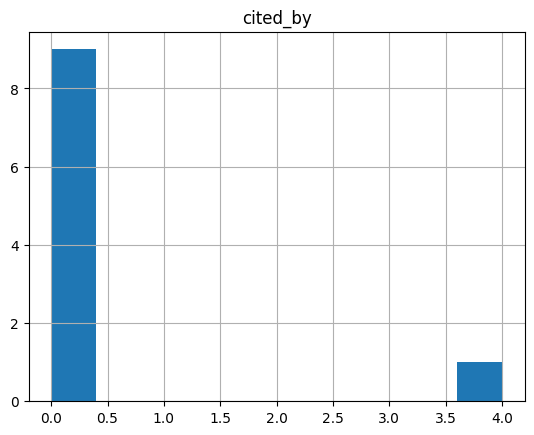

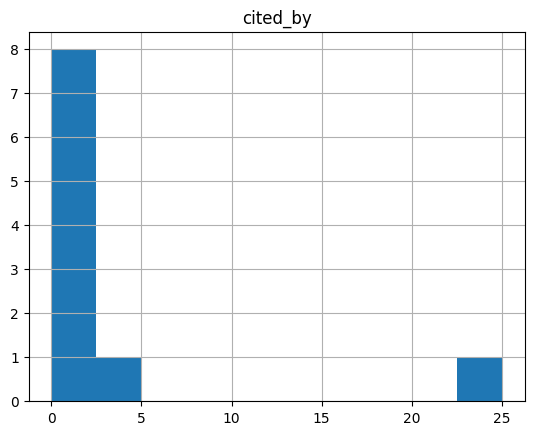

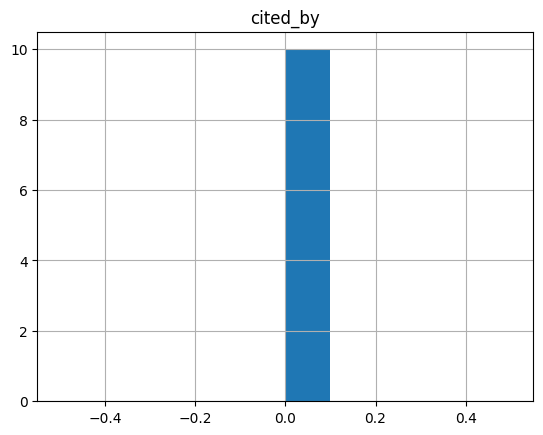

In [135]:
# cited by count
print(df_data.columns)
df_data_citedby = df_data[['type','DOI','cited_by']]
df_data_citedby.groupby('type')['cited_by'].agg(['mean','median','max','min'])

# ****** ADD VIZ HERE ********
df_data_citedby.groupby(level=0).hist()

# license analysis
- [ ] license version and url/type
    - type ,count, %, common or proprietary 
## subset analysis
- [ ] License - identification of locations, difference between REST and XML API?
- types:
    - [ ] errors in consistency, conventions such as with CC-BY, etc. 
    - [ ] coded for incorrect values, missing info, and inconsistent value rep
    - [ ] sample of types that are non-CC

In [168]:
# license version and url by type
print(df_data.columns)
df_data_license = df_data[['type','DOI','license_version','license_type']]
print(Fore.LIGHTCYAN_EX + f"\n-----\n{df_data_license.groupby(['type','license_version'])['license_type'].count()}")
print(Fore.LIGHTYELLOW_EX + f"\n------\n{df_data_license.groupby(['type','license_type'])['license_type'].count()}")
df_data_license_2 = pd.DataFrame(df_data_license.groupby(['type']).agg({'DOI':'count','license_version':'count'}))

df_data_license_2.loc[:,'percentage'] = df_data_license_2['license_version']/df_data_license_2['DOI']*100
df_data_license_2

Index(['DOI', 'type', 'title', 'abstract', 'language', 'cited_by', 'url',
       'license_version', 'license_type'],
      dtype='object')

-----
type                      license_version
book-chapter:None         unspecified        1
journal-article:None      unspecified        3
                          vor                5
proceedings-article:None  vor                2
Name: license_type, dtype: int64

------
type                      license_type                                                                       
book-chapter:None         https://creativecommons.org/licenses/by-nc/4.0/                                        1
journal-article:None      http://creativecommons.org/licenses/by/4.0/                                            1
                          https://academic.oup.com/pages/standard-publication-reuse-rights                       1
                          https://creativecommons.org/licenses/by-nc-sa/4.0                                      1
             

,DOI,license_version,percentage
type,,,
book-chapter:None,10,1,10.0
journal-article:None,10,8,80.0
proceedings-article:None,10,2,20.0


- [ ] language
    - type, count of each type, % in abstract, % in journal level attribution

In [ ]:
# language